In [5]:
import os
# Install java
#!sudo apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

dataFile="gs://marketing-campaigns/bank-full.csv"
RANDOM_STATE=545510477

In [2]:
def loadTrainingData(dataFile):
    pdBankDF = pd.read_csv(dataFile,sep=";")
    pdBankDF.head(2)
    return pdBankDF

In [57]:
bankDF = loadTrainingData(dataFile)
bankDF.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


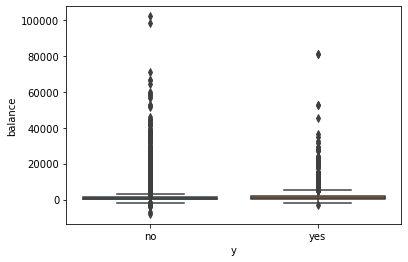

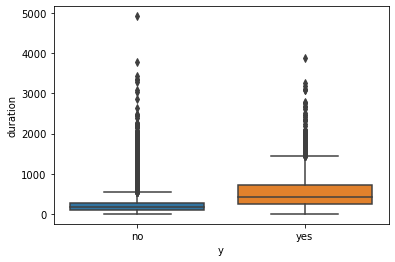

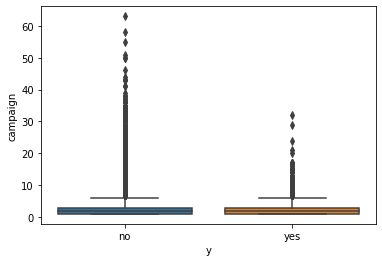

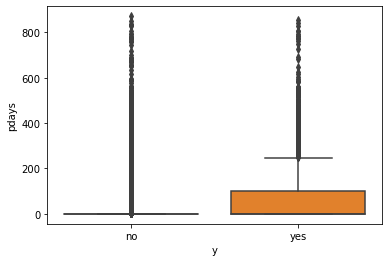

In [89]:
for var in ['balance','duration','campaign','pdays']:
    sns.boxplot(x='y',y=var,data=bankDF)
    plt.show()

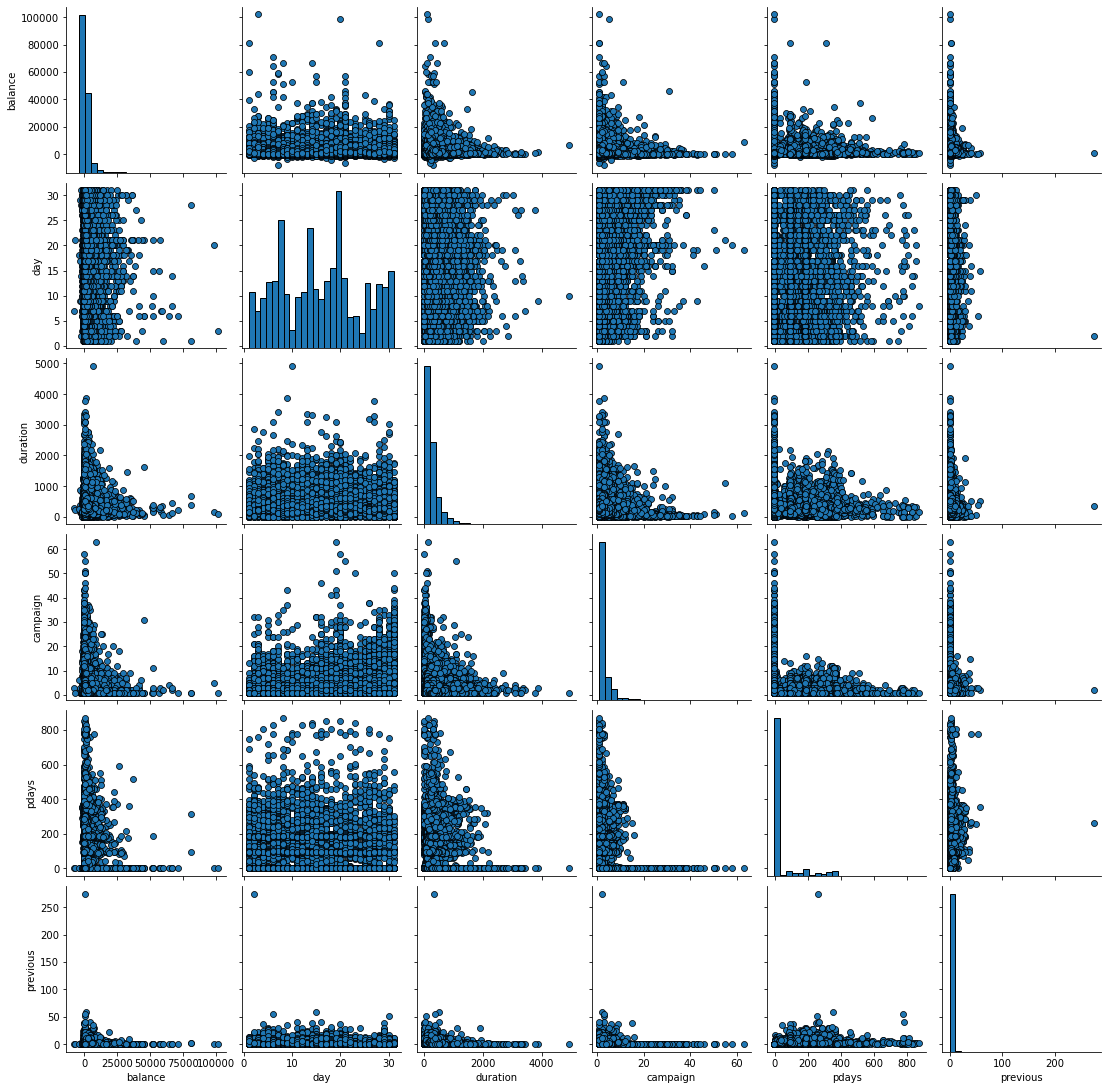

In [87]:
sns.pairplot(data=bankDF[bankDF.columns[1:]],diag_kws={'edgecolor':'k','bins':25},plot_kws={'edgecolor':'k'})
plt.show()

In [83]:
signedUpUsers = bankDF[bankDF['y']=='yes']
signedUpUsers.head(2)

maritalStatusBySignup = bankDF.groupby(['marital','y'])['y'].agg(maritalCat='count').reset_index()
maritalStatusBySignup

,marital,y,maritalCat
0,divorced,no,4585
1,divorced,yes,622
2,married,no,24459
3,married,yes,2755
4,single,no,10878
5,single,yes,1912


In [84]:
maritalStatusTot = bankDF.groupby(['marital'])['y'].agg(maritalTot='count').reset_index()
maritalStatusTot

,marital,maritalTot
0,divorced,5207
1,married,27214
2,single,12790


In [143]:
maritalComb = pd.merge(maritalStatusTot, maritalStatusBySignup, on = ['marital'])
maritalComb['maritalCatPercent'] = (maritalComb.maritalCat / maritalComb.maritalTot)*100
maritalComb

,marital,maritalTot,y,maritalCat,maritalCatPercent
0,divorced,5207,no,4585,88.054542
1,divorced,5207,yes,622,11.945458
2,married,27214,no,24459,89.876534
3,married,27214,yes,2755,10.123466
4,single,12790,no,10878,85.050821
5,single,12790,yes,1912,14.949179


In [144]:
jobBySignup = bankDF.groupby(['job','y'])['y'].agg(jobCat='count').reset_index()
jobBySignup
jobTot = bankDF.groupby(['job'])['y'].agg(jobTot='count').reset_index()
jobTot
jobComb = pd.merge(jobTot, jobBySignup, on = ['job'])
jobComb['jobCatPercent'] = (jobComb.jobCat / jobComb.jobTot)*100
jobComb

,job,jobTot,y,jobCat,jobCatPercent
0,admin.,5171,no,4540,87.797331
1,admin.,5171,yes,631,12.202669
2,blue-collar,9732,no,9024,92.725031
3,blue-collar,9732,yes,708,7.274969
4,entrepreneur,1487,no,1364,91.728312
5,entrepreneur,1487,yes,123,8.271688
6,housemaid,1240,no,1131,91.209677
7,housemaid,1240,yes,109,8.790323
8,management,9458,no,8157,86.244449
9,management,9458,yes,1301,13.755551


In [145]:
orderdData = jobComb.sort_values(by=['y','jobCatPercent'],ascending=False)
orderdData = orderdData[orderdData['y']=='yes']
orderdData

,job,jobTot,y,jobCat,jobCatPercent
17,student,938,yes,269,28.678038
11,retired,2264,yes,516,22.791519
21,unemployed,1303,yes,202,15.502686
9,management,9458,yes,1301,13.755551
1,admin.,5171,yes,631,12.202669
13,self-employed,1579,yes,187,11.842939
23,unknown,288,yes,34,11.805556
19,technician,7597,yes,840,11.056996
15,services,4154,yes,369,8.883004
7,housemaid,1240,yes,109,8.790323


In [146]:
orderdData = jobComb.sort_values(by=['y','jobCatPercent'],ascending=False)
orderdData = orderdData[orderdData['y']=='no']
orderdData

,job,jobTot,y,jobCat,jobCatPercent
2,blue-collar,9732,no,9024,92.725031
4,entrepreneur,1487,no,1364,91.728312
6,housemaid,1240,no,1131,91.209677
14,services,4154,no,3785,91.116996
18,technician,7597,no,6757,88.943004
22,unknown,288,no,254,88.194444
12,self-employed,1579,no,1392,88.157061
0,admin.,5171,no,4540,87.797331
8,management,9458,no,8157,86.244449
20,unemployed,1303,no,1101,84.497314


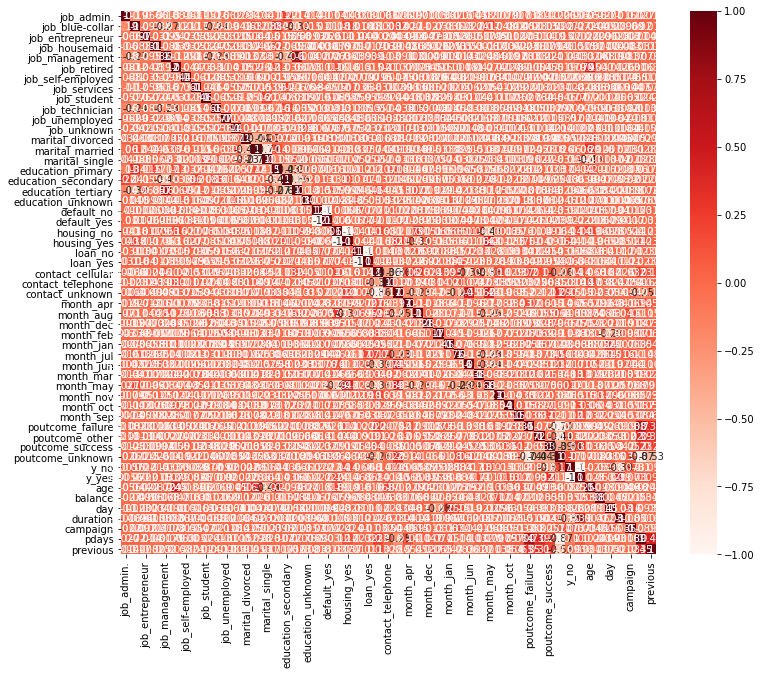

In [29]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

#bankDF['y'] = labelencoder.fit_transform(bankDF['y'])
bankCat = pd.get_dummies(bankDF[['job','marital','education','default','housing','loan','contact','month','poutcome','y']])
bankNum = bankDF[['age','balance','day','duration','campaign','pdays','previous']]
numericBankDF = pd.concat([bankCat, bankNum], axis=1)
plt.figure(figsize=(12,10))
cor = numericBankDF.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [51]:
print(" 'Yes': {}".format(sum(numericBankDF['y_yes']==1)))
print(" 'No': {}".format(sum(numericBankDF['y_yes']==0)))

 'Yes': 5289
 'No': 39922


In [56]:
cor_target = abs(cor["y_yes"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

housing_no          0.139173
housing_yes         0.139173
contact_cellular    0.135873
contact_unknown     0.150935
month_mar           0.129456
month_may           0.102500
month_oct           0.128531
month_sep           0.123185
poutcome_success    0.306788
poutcome_unknown    0.167051
y_no                1.000000
y_yes               1.000000
duration            0.394521
pdays               0.103621
Name: y_yes, dtype: float64

In [55]:
cor_target = abs(cor["y_no"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

poutcome_success    0.306788
y_no                1.000000
y_yes               1.000000
duration            0.394521
Name: y_no, dtype: float64

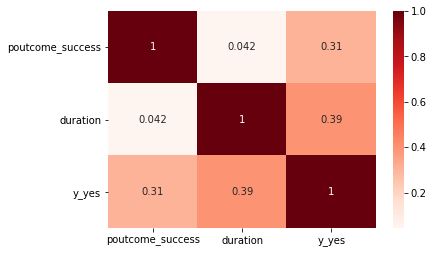

In [122]:
plt.figure(figsize=(6,4))
cor = numericBankDF[['poutcome_success','duration','y_yes']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [91]:
#poutcome: outcome of the previous marketing campaign "success"
print(numericBankDF[["poutcome_success","duration"]].corr())

                  poutcome_success  duration
poutcome_success          1.000000  0.042389
duration                  0.042389  1.000000


In [93]:
numericBankDF.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'y_no', 'y_yes', 'age', 'balance', 'day',
       'duration', 'campaign', 'pdays', 'previous'],
      dtype='object')

In [ ]:
def class_convert(response):
    if response=='yes':
        return 1
    else:
        return 0

bankDF['response']=bankDF['y'].apply(class_convert)

In [125]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

cols = ['job_entrepreneur','job_housemaid',
       'job_management', 'job_retired', 'job_services',
        'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown','age', 'balance', 'day','duration', 'campaign', 'pdays', 'previous']

formula = 'y_yes ~ ' + '+'.join(cols)
formula


'y_yes ~ job_entrepreneur+job_housemaid+job_management+job_retired+job_services+job_student+job_technician+job_unemployed+job_unknown+marital_divorced+marital_married+marital_single+education_primary+education_secondary+education_tertiary+education_unknown+default_no+default_yes+housing_no+housing_yes+loan_no+loan_yes+contact_cellular+contact_telephone+contact_unknown+month_apr+month_aug+month_dec+month_feb+month_jan+month_jul+month_jun+month_mar+month_may+month_nov+month_oct+month_sep+poutcome_failure+poutcome_other+poutcome_success+poutcome_unknown+age+balance+day+duration+campaign+pdays+previous'

In [126]:
model = smf.glm(formula = formula, data=numericBankDF, family=sm.families.Binomial())
result=model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  y_yes   No. Observations:                45211
Model:                            GLM   Df Residuals:                    45170
Model Family:                Binomial   Df Model:                           40
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10791.
Date:                Sun, 25 Oct 2020   Deviance:                       21582.
Time:                        19:34:41   Pearson chi2:                 1.27e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.8252    

In [130]:
from statsmodels.graphics.api import abline_plot
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
cols = ['job_housemaid','job_retired',
       'job_student', 'marital_divorced', 'marital_married',
        'marital_single', 'education_primary', 'education_secondary',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'balance', 'day','duration', 'campaign']

formula = 'y_yes ~ ' + '+'.join(cols)

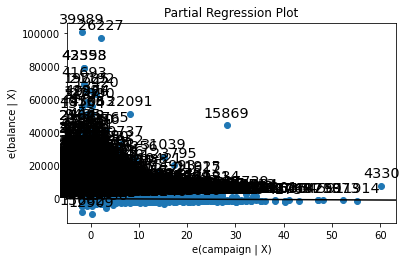

In [142]:
fig = sm.graphics.plot_partregress("balance", "campaign", ["job_retired"], data=numericBankDF)
fig.tight_layout(pad=2.0)